# 房屋价格预测
# 评价指标：RMSE均方根误差 （对异常值敏感）

# 1 读取数据，认识数据

<function matplotlib.pyplot.show(*args, **kw)>

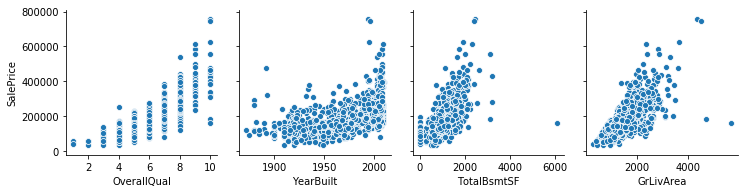

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df=pd.read_csv("./dataset/train.csv",index_col=0)  #去掉id索引列
test_df=pd.read_csv("./dataset/test.csv",index_col=0)
train_df.head()

#改进之处
#根据业务发现OverallQual:房屋的材料与装修评价、YearBuilt：建造年份、TotalBsmtSF：地下室总面积、GrLivArea:地上居住面积 ,四个特征具有很重要的影响，因此对此四个特征进行分析
figure=plt.figure
#pairplot主要展现的是变量两两之间的关系，dropna表示是否剔除缺失值
sns.pairplot(x_vars=['OverallQual','YearBuilt','TotalBsmtSF','GrLivArea'],y_vars=['SalePrice'],data=train_df,dropna=True)
plt.show

In [98]:
#根据上图来剔除离群点
train_df.drop(train_df[(train_df['OverallQual']<5) & (train_df['SalePrice']>200000)].index,inplace=True)
train_df.drop(train_df[(train_df['YearBuilt']<1900) & (train_df['SalePrice']>400000)].index,inplace=True)
train_df.drop(train_df[(train_df['TotalBsmtSF']>6000) & (train_df['SalePrice']<400000)].index,inplace=True)
train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<400000)].index,inplace=True)
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


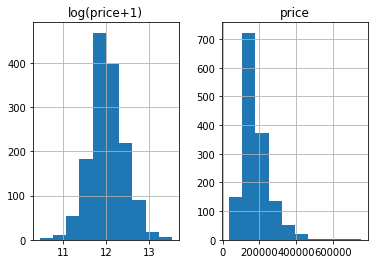

(2915, 79)

In [99]:
#查看标签值的分布
prices=pd.DataFrame({'price':train_df['SalePrice'],'log(price+1)':np.log1p(train_df['SalePrice'])})
prices.hist()  #画直方图
plt.show()
y_train=np.log1p(train_df.pop('SalePrice'))  #作为标签值
#然后合并train和test数据集,此时train数据集已经没有SalePrice这一列了
df=pd.concat((train_df,test_df),axis=0)
df.shape

因为label本身并不平滑，为了我们分类器的学习更加准确，我们需要首先把label给**平滑化（正态化）**。我在这里使用的是**log1p, 也就是 log(x+1)**。要注意的是我们这一步把数据平滑化了，在最后算结果的时候，**还要把预测到的平滑数据给变回去，那么log1p()的反函数就是expm1()**，后面用到时再具体细说。



# 2 数据预处理

In [100]:
print(pd.isnull(df).sum())  #查看数据中各特征缺失值情况

MSSubClass         0
MSZoning           4
LotFrontage      485
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 79, dtype: int64


In [101]:
#上面不方便观察，故先查看缺失值最多的10个特征
df.isnull().sum().sort_values(ascending=False).head(10)

PoolQC          2906
MiscFeature     2810
Alley           2717
Fence           2345
FireplaceQu     1420
LotFrontage      485
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
dtype: int64

In [102]:
#为了更清楚的表示，我们用缺失率来考察缺失情况：
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'缺失率': df_na})
missing_data.head(10)


,缺失率
PoolQC,99.691252
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.638079
GarageFinish,5.454545
GarageYrBlt,5.454545
GarageQual,5.454545
GarageCond,5.454545


Text(0.5, 1.0, 'Percent missing data by feature')

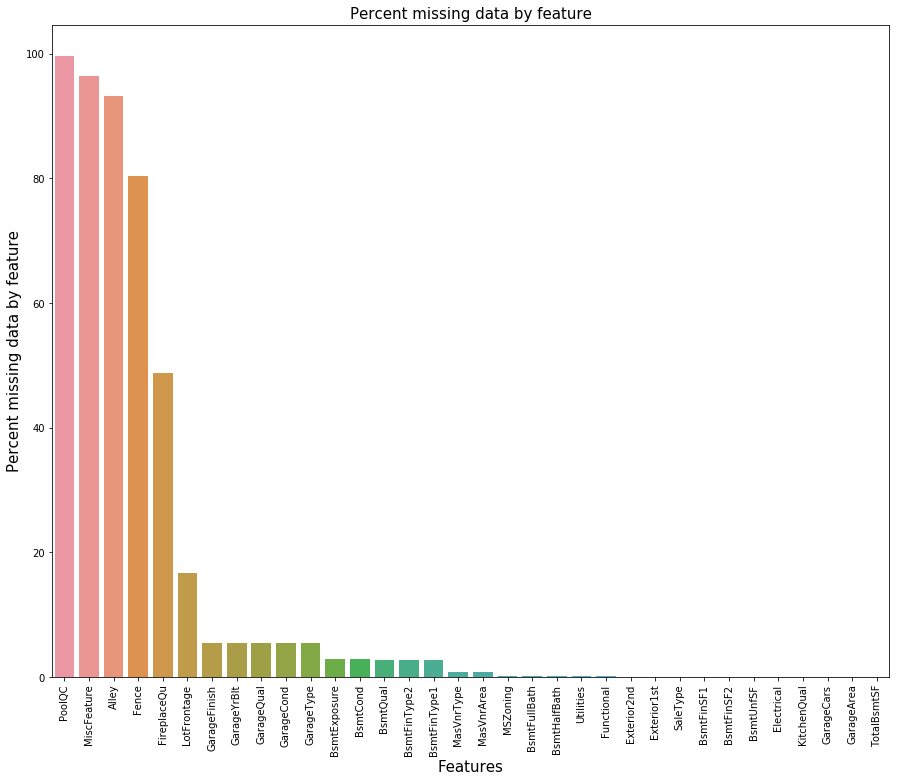

In [103]:
#对其可视化
import seaborn as sns
f,ax=plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')   #横坐标的值旋转90°
sns.barplot(x=df_na.index,y=df_na)
plt.xlabel('Features',fontsize=15)
plt.ylabel('Percent missing data by feature',fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)


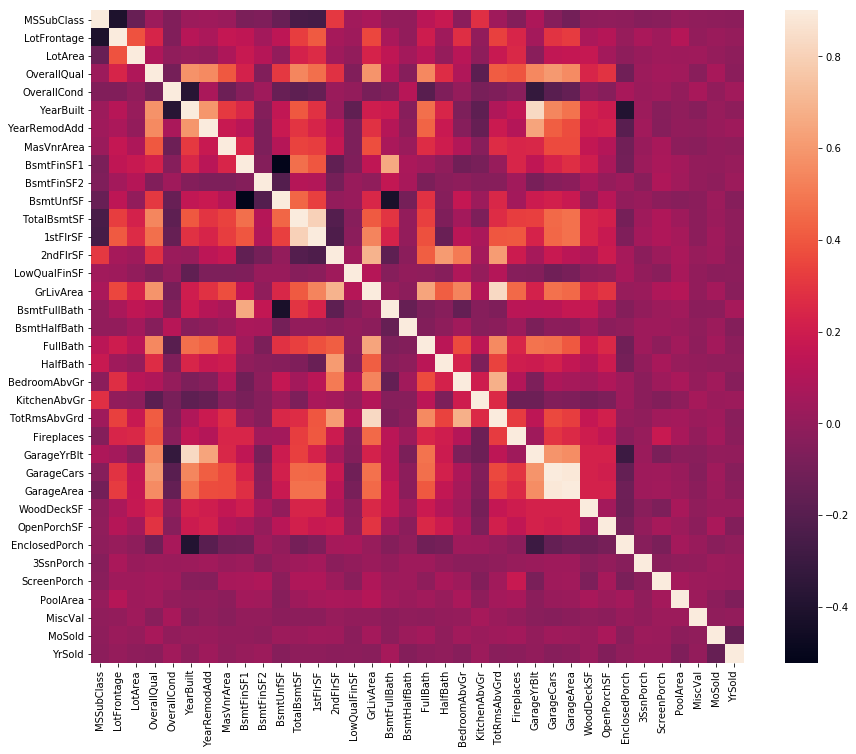

In [104]:
#对每个特征进行相关性分析，查看热力图：
corrmat=train_df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat,vmax=0.9,square=True)

#我们看到有些特征相关性大，容易造成过拟合现象，因此需要进行剔除。在下一篇的数据挖掘篇我们来对这些特征进行处理并训练模型。



In [105]:
#MSSubClass 其实是一个 category 的值：
df['MSSubClass'].dtypes
#它不应该做为数值型的值进行统计。因此，进行强制类型转换，把它变回 string：
df['MSSubClass'] =df['MSSubClass'].astype(str)
df['MSSubClass'].value_counts()  #统计频次

20     1078
60      573
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       22
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

## 当我们用 numerical 来表达 categorical 的时候要注意，数字本身有大小的含义，所以乱用数字会给之后的模型学习带来麻烦。这里我们可以用 One-Hot 的方法来表达 category。pandas 自带的get_dummies方法，可以做到一键 One-Hot：


In [106]:
pd.get_dummies(df['MSSubClass'], prefix='MSSubClass').head()
#然后将所有category数据全部one-hot
all_dummy_df = pd.get_dummies(df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


## 然后处理numerical型数据的缺失值

In [107]:
#查看one-hot后的缺失值,这里只剩numerical型数据的缺失值
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     485
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
dtype: int64

In [108]:
#这里采用平均值来填充空缺：
mean_cols = all_dummy_df.mean()
all_dummy_df = all_dummy_df.fillna(mean_cols)


## 至此，已经完成了对数据的基本处理，包括对categorical数据的one-hot以及对numerical型数据缺失值的填充，这里还需要对数据进行标准化，使得数据在一个相同分布的范围内。我们对那些本来就是 numerical 的数据进行处理（与 One-Hot 的 0/1 数据不同）。

In [109]:
#首先查看哪些是numerical型的数据
numeric_cols = df.columns[df.dtypes != 'object']
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [110]:
#这里采用公式(x-x')/s来处理
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.200487,-0.215097,0.650801,-0.506891,1.046889,0.897604,0.529650,0.601491,-0.293298,-0.934125,...,0,0,0,1,0,0,0,0,1,0
1,0.520339,-0.067000,-0.061051,2.191079,0.154623,-0.394384,-0.572428,1.214094,-0.293298,-0.629283,...,0,0,0,1,0,0,0,0,1,0
2,-0.056321,0.145488,0.650801,-0.506891,0.980795,0.849753,0.338473,0.106003,-0.293298,-0.288043,...,0,0,0,1,0,0,0,0,1,0
3,-0.440762,-0.073439,0.650801,-0.506891,-1.861236,-0.681493,-0.572428,-0.502095,-0.293298,-0.046899,...,0,0,0,1,1,0,0,0,0,0
4,0.712560,0.533116,1.362653,-0.506891,0.947748,0.754050,1.395568,0.486628,-0.293298,-0.160646,...,0,0,0,1,0,0,0,0,1,0


# 3建立模型

In [111]:
#首先需要把数据集重新划分为训练集和测试集
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]
#这里将DataFrame转换成Numpy Array格式
X_train = dummy_train_df.values
X_test = dummy_test_df.values

## 3.1 利用Ridge Regression模型
### 因为对于多因子的数据集，这种模型可以方便的把所有的变量都一股脑的放进去

In [47]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
alphas=np.logspace(-3,2,50)  #构造的是一个从10的-3次方到10的2次方的等比数列，这个等比数列的长度是50个元素
test_scores=[]
for alpha in alphas:
    clf=Ridge(alpha)
    test_score=np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0, 0.5, 'CV Error')

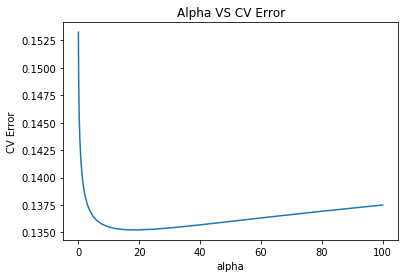

In [48]:
plt.plot(alphas,test_scores)
plt.title("Alpha VS CV Error")
plt.xlabel("alpha")
plt.ylabel("CV Error")

In [49]:
print(cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))

[-0.01536326 -0.01112145 -0.01260426 -0.0318634  -0.02131609 -0.01190385
 -0.01613769 -0.01148982 -0.05523603 -0.01702457]


## 3.2 模型集成之Bagging
Bagging把很多的小分类器放在一起，每个训练随机的一部分数据，然后采用多数多数投票机制把他们的最终结果综合起来

Text(0, 0.5, 'error')

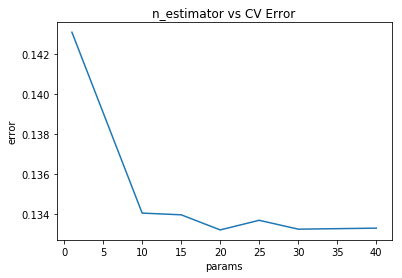

In [50]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score

params=[1,10,15,20,25,30,40]     #学习器个数
test_scores=[]
for param in params:
    clf1=BaggingRegressor(n_estimators=param,base_estimator=Ridge(15))
    test_score1=np.sqrt(-cross_val_score(clf1,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score1))
plt.plot(params,test_scores)
plt.title("n_estimator vs CV Error")
plt.xlabel("params")
plt.ylabel("error")

## 3.3  模型集成之Boosting
### Boosting原理：把分类器线性排列，下一个分类器把上一个分类器分类不好的样本加上更高的权重，这样下一个分类器就能在这个部分学的更加深刻

Text(0.5, 1.0, 'Boosting vs CV Error')

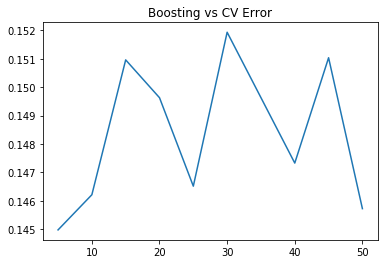

In [56]:
from sklearn.ensemble import AdaBoostRegressor
params=[5,10,15,20,25,30,40,45,50]     #学习器个数
test_scores=[]
for param in params:
    clf=AdaBoostRegressor(n_estimators=param,base_estimator=Ridge(100))
    test_score=np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.plot(params,test_scores)
plt.title("Boosting vs CV Error")


## 3.4 xgboost

Text(0.5, 1.0, 'XGBoosting vs CV Error')

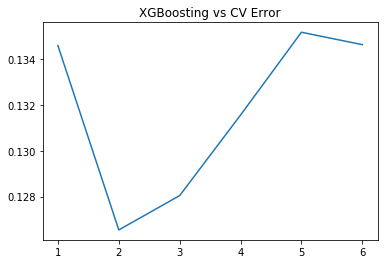

In [57]:
from xgboost import XGBRegressor

params=[1,2,3,4,5,6]    #决策树的个数
test_scores=[]
for param in params:
    clf=XGBRegressor(max_depth=param)
    test_score=np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.plot(params,test_scores)
plt.title("XGBoosting vs CV Error")

## 3.5 Stacking

In [116]:
#第一层基模型选择Ridge、 Lasso、ElasticNet、lightgbm四种，第二层模型选用Lasso。模型融合过程代码如下(可以先做一下网格搜索，寻找合适的算法超参)：
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold,GridSearchCV
nF = 20
kf = KFold(n_splits=nF, random_state=241, shuffle=True)
test_errors_l2 = []
train_errors_l2 = []
test_errors_l1 = []
train_errors_l1 = []
test_errors_GBR = []
train_errors_GBR = []
test_errors_ENet = []
test_errors_LGB = []
test_errors_stack = []
test_errors_ens = []
train_errors_ens = []
models = []
pred_all = []
ifold = 1
for train_index,test_index in kf.split(X_train):
    ifold=ifold+1
    trainset,testset=X_train[train_index],X_train[test_index]
    train_label,test_label=y_train[train_index],y_train[test_index]
    #Ridge
    ridge_clf=Ridge(15)
    ridge_clf.fit(trainset,train_label)
    predict_train_ridge=ridge_clf.predict(trainset)
    pred_test_ridge=ridge_clf.predict(testset)

    # lasso
    l1Regr = make_pipeline(RobustScaler(), Lasso(alpha = 0.0003, random_state=1, max_iter=50000))
    l1Regr.fit(trainset, train_label)
    pred_train_lasso = l1Regr.predict(trainset)
    pred_test_lasso = l1Regr.predict(testset)
    
    # GBR      
    myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 5) 
    
    myGBR.fit(trainset,train_label)
    pred_train_GBR = myGBR.predict(trainset)

    pred_test_GBR = myGBR.predict(testset)
    
    # ENet
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=4.0, l1_ratio=0.005, random_state=3))
    ENet.fit(trainset,train_label)
    pred_train_ENet = ENet.predict(trainset)
    pred_test_ENet = ENet.predict(testset) 
    
    # LGB
    myLGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=600,
                              max_bin = 50, bagging_fraction = 0.6,
                              bagging_freq = 5, feature_fraction = 0.25,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)
    myLGB.fit(trainset,train_label)
    pred_train_LGB = myLGB.predict(trainset)
    pred_test_LGB = myLGB.predict(testset)      
    # Stacking
    stackedset = pd.DataFrame({'A' : []})
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_ridge)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_lasso)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_GBR)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_ENet)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_LGB)],axis=1)
    Xstack = np.array(stackedset)
    Xstack = np.delete(Xstack, 0, axis=1)
    l1_staked = Lasso(alpha = 0.0001,fit_intercept = True)
    l1_staked.fit(Xstack, test_label)
    pred_test_stack = l1_staked.predict(Xstack)
    models.append([ridge_clf,l1Regr,myGBR,ENet,myLGB,l1_staked])



In [117]:
M=X_test.shape[0]
scores_fin = 1+np.zeros(M)
for m in models:
    ger=m[0]
    las=m[1]
    gbr=m[2]
    Enet=m[3]
    lgb=m[4]
    las2=m[5]
    ger_predict=ger.predict(X_test)
    las_predict=las.predict(X_test)
    gbr_predict=gbr.predict(X_test)
    Enet_predict=Enet.predict(X_test)
    lgb_predict=lgb.predict(X_test)
    X_stack=pd.DataFrame({"A":[]})
    X_stack=pd.concat([X_stack,pd.DataFrame(ger_predict),pd.DataFrame(las_predict),pd.DataFrame(gbr_predict),pd.DataFrame(Enet_predict),pd.DataFrame(lgb_predict)],axis=1)
    X_stack=np.array(X_stack)
    X_stack=np.delete(X_stack,0,1)
    scores_fin=scores_fin*(las2.predict(X_stack))
scores_fin = scores_fin ** (1/nF)



In [119]:
y_predict=np.expm1(scores_fin)  #前面对标签值取了log，这里得还原回去
submission_df=pd.DataFrame({'Id':test_df.index,'SalePrice':y_predict})
submission_df.head()

,Id,SalePrice
0,1461,122201.563458
1,1462,154810.290150
2,1463,185727.597080
3,1464,198377.397393
4,1465,191944.356677


In [120]:
#将结果保存为.csv文件
submission_df.to_csv('submission_stacking.csv',index=False)

# 4、提交结果

In [62]:
xgb=XGBRegressor(max_depth=2)  #根据交叉验证找到了最优的参数
xgb.fit(X_train,y_train)    #对数据进行训练
y_predict=np.expm1(xgb.predict(X_test))  #前面对标签值取了log，这里得还原回去
submission_df=pd.DataFrame({'Id':test_df.index,'SalePrice':y_predict})
submission_df.head()

,Id,SalePrice
0,1461,125922.414062
1,1462,157918.703125
2,1463,188508.015625
3,1464,193684.171875
4,1465,186918.703125


In [64]:
#将结果保存为.csv文件
submission_df.to_csv('submission.csv',index=False)